# Assignment 2

In this assignment you will create a coordinate-based multilayer perceptron in numpy from scratch. For each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

You will then compare the following input feature mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.

Some notes to help you with that:

- You will implement the mappings in the helper functions `get_B_dict` and `input_mapping`. 
- The basic mapping can be considered a case where $\mathbf B \in \mathbb R^{2 \times 2}$ is the indentity matrix. 
- For this assignment, $d$ is 2 because the input coordinates in two dimensions. 
- You can experiment with $m$ and $\sigma$ values e.g. $m=256$ and $\sigma \in \{1, 10, 100\}$.

Source: https://bmild.github.io/fourfeat/ 
This assignment is inspired by and built off of the authors' demo. 

## Setup

### (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. Replace the path below with the path in your Google Drive to the uploaded assignment folder. Mounting to Google Drive will allow you access the other .py files in the assignment folder and save outputs to this folder

In [1]:
# you will be prompted with a window asking to grant permissions
# click connect to google drive, choose your account, and click allow
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google'

In [ ]:
# TODO: fill in the path in your Google Drive in the string below
# Note: do not escape slashes or spaces in the path string
import os
datadir = "/content/assignment2"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/path/to/your/assignment2/" $datadir
os.chdir(datadir)
!pwd

### Imports

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np
import random

# imports /content/assignment2/models/neural_net.py if you mounted correctly 
from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  

## Helper Functions

### Experiment Runner (Fill in TODOs)

In [67]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt):

  # Initialize a new neural network model
  net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers)

  # Variables to store performance for each epoch
  train_loss = np.zeros(epochs)
  train_psnr = np.zeros(epochs)
  test_psnr = np.zeros(epochs)
  predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))
  
  batch_size = 5

  # For each epoch...
  for epoch in tqdm(range(epochs)):
      # Shuffle the dataset
      train_data = np.hstack((X_train, y_train))
      np.random.shuffle(train_data)
      X_train_shuffle = train_data[:, 0:X_train.shape[1]]
      y_train_shuffle = train_data[:, -3:]

      # Training
      # Run the forward pass of the model to get a prediction and record the psnr
      output = net.forward(X_train_shuffle)
      train_psnr[epoch] = psnr(y_train_shuffle, output)

      # Run the backward pass of the model to compute the loss, record the loss, and update the weights
      loss = net.backward(y_train_shuffle)
      train_loss[epoch] = loss
      net.update(lr=learning_rate, opt=opt)

      # Testing
      # No need to run the backward pass here, just run the forward pass to compute and record the psnr
      predict = net.forward(X_test)
      test_psnr[epoch] = psnr(y_test, predict)
      predicted_images[epoch] = predict
        
  return net, train_psnr, test_psnr, train_loss, predicted_images

### Image Data and Feature Mappings (Fill in TODOs)

In [4]:
# Data loader - already done for you
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

  # Download image, take a square crop from the center  
  img = imageio.imread(image_url)[..., :3] / 255.
  c = [img.shape[0]//2, img.shape[1]//2]
  r = 256
  img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

  if size != 512:
    img = cv2.resize(img, (size, size))

  plt.imshow(img)
  plt.show()

  # Create input pixel coordinates in the unit square
  coords = np.linspace(0, 1, img.shape[0], endpoint=False)
  x_test = np.stack(np.meshgrid(coords, coords), -1)
  test_data = [x_test, img]
  train_data = [x_test[::2, ::2], img[::2, ::2]]

  return train_data, test_data

In [75]:
# Create the mappings dictionary of matrix B -  you will implement this
def get_B_dict():
  B_dict = {}
  B_dict['none'] = None
  
  # add B matrix for basic, gauss_1.0, gauss_10.0, gauss_100.0
  B_dict['basic'] = np.array([[1, 1], [1, 1]])
  B_dict['gauss_1.0'] = np.random.normal(0, 1.0, size=(512, 2))
  B_dict['gauss_10.0'] = np.random.normal(0, 10.0, size=(512, 2))
  B_dict['gauss_100.0'] = np.random.normal(0, 100.0, size=(512, 2))
    
  return B_dict

In [6]:
# Given tensor x of input coordinates, map it using B - you will implement
def input_mapping(x, B):
  if B is None:
    # "none" mapping - just returns the original input coordinates
    return x
  else:
    # "basic" mapping and "gauss_X" mappings project input features using B
    col_1 = np.cos(2 * np.pi * np.matmul(B, x.T))
    col_2 = np.sin(2 * np.pi * np.matmul(B, x.T))
    mat = np.vstack((col_1, col_2))
    return mat.T

In [7]:
# Apply the input feature mapping to the train and test data - already done for you
def get_input_features(B_dict, mapping):
  # mapping is the key to the B_dict, which has the value of B
  # B is then used with the function `input_mapping` to map x
  y_train = train_data[1].reshape(-1, 3) 
  y_test = test_data[1].reshape(-1, 3)
  X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
  X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
  return X_train, y_train, X_test, y_test

### MSE Loss and PSNR Error (Fill in TODOs)

In [8]:
def mse(y, p):
  loss = np.sum(np.sum((y - p) * (y - p), axis=1))
  return loss * (1 / y.shape[0])

def psnr(y, p):
  mse_loss = mse(y, p)
  if(mse == 0):  
      return 100
  max_pixel = 255.0
  psnr = 20 * np.log10(max_pixel / np.sqrt(mse_loss))
  return psnr

### Plotting

In [9]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
  # plot the training loss
  plt.subplot(2, 1, 1)
  plt.plot(train_loss)
  plt.title('MSE history')
  plt.xlabel('Iteration')
  plt.ylabel('MSE Loss')

  # plot the training and testing psnr
  plt.subplot(2, 1, 2)
  plt.plot(train_psnr, label='train')
  plt.plot(test_psnr, label='test')
  plt.title('PSNR history')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [10]:
def plot_reconstruction(p, y_test):
  p_im = p.reshape(size,size,3)
  y_im = y_test.reshape(size,size,3)

  plt.figure(figsize=(12,6))

  # plot the reconstruction of the image
  plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

  # plot the ground truth image
  plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

  print("Final Test MSE", mse(y_test, p))
  print("Final Test psnr",psnr(y_test, p))

In [11]:
def plot_reconstruction_progress(predicted_images, y_test, N=8):
  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j].reshape(size,size,3))
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y_test.reshape(size,size,3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

In [45]:
def plot_feature_mapping_comparison(outputs, gt):
  # plot reconstruction images for each mapping
  plt.figure(figsize=(24, 4))
  N = len(outputs)
  for i, k in enumerate(outputs):
      plt.subplot(1, N+1, i+1)
      plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
      plt.title(k)
  plt.subplot(1, N+1, N+1)
  plt.imshow(gt)
  plt.title('GT')
  plt.show()

  # plot train/test error curves for each mapping
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

In [12]:
# Save out video
def create_and_visualize_video(outputs, size=size, epochs=epochs, filename='training_convergence.mp4'):
  all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
  data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
  f = os.path.join(filename)
  imageio.mimwrite(f, data8, fps=20)

  # Display video inline
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(f, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  N = len(outputs)
  if N == 1:
    return HTML(f'''
    <video width=256 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')
  else:
    return HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))

NameError: name 'size' is not defined

# Low Resolution Reconstruction

/tmp/ipykernel_6879/2979632171.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


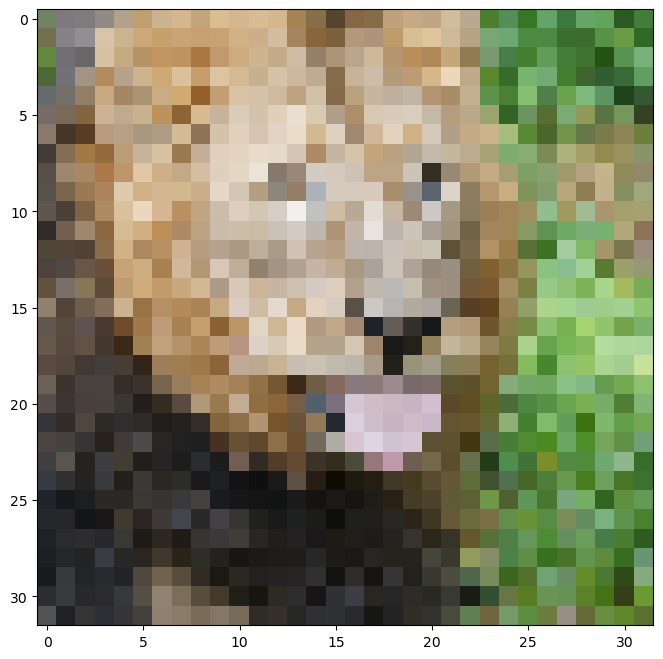

In [13]:
size = 32
train_data, test_data = get_image(size)

Some suggested hyperparameter choices to help you start
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning reate: 1e-4


#### Low Resolution Reconstruction - SGD - None Mapping

  0%|          | 0/1000 [00:00<?, ?it/s]

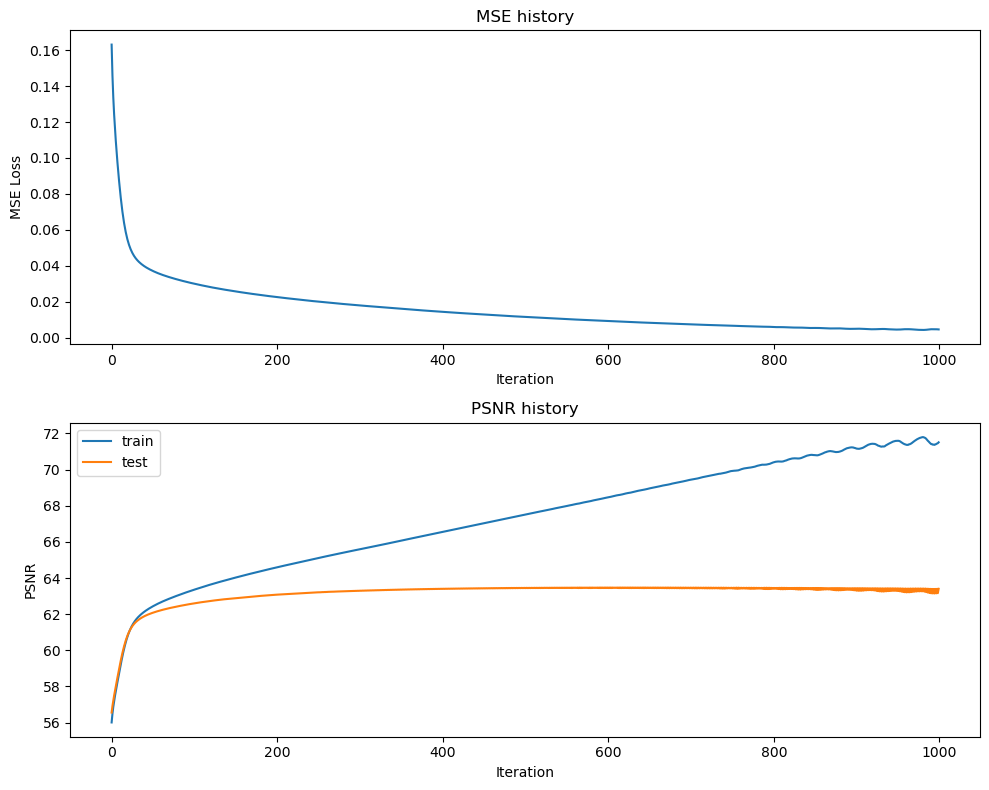

Final Test MSE 0.029694112860427307
Final Test psnr 63.40410006017501


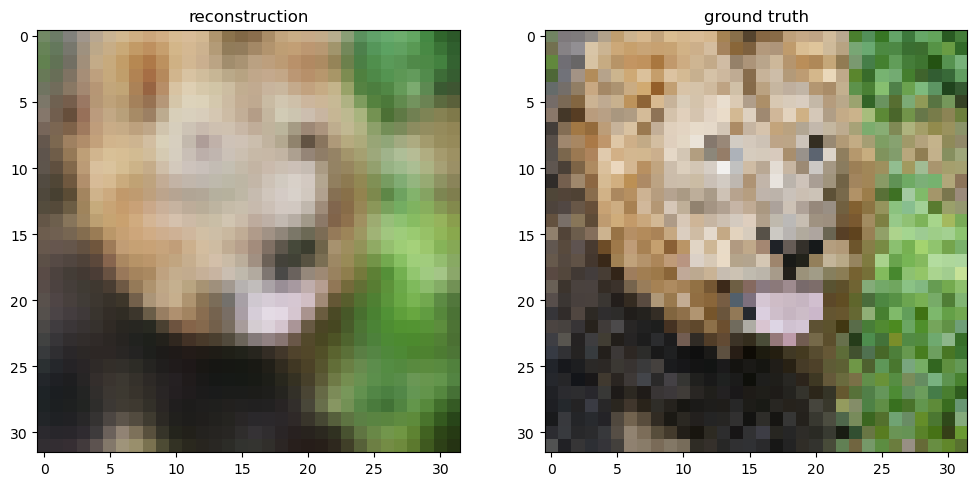

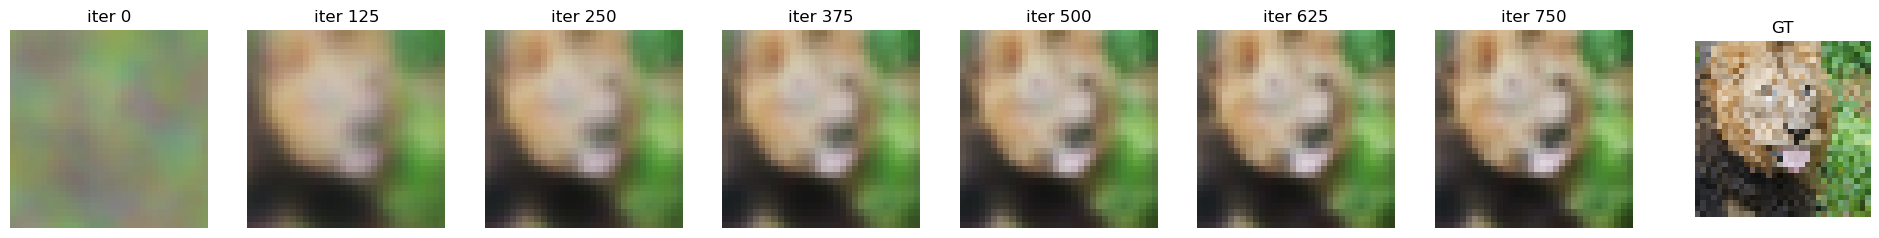

In [81]:
# get input features
B_dict = get_B_dict()
mapping = 'gauss_1.0'       # None Mapping
X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)

# run NN experiment on input features
input_size = X_train.shape[1]
num_layers = 4
hidden_size = 256
hidden_sizes = [hidden_size] * (num_layers - 1)
output_size = train_data[1].shape[2]
epochs = 1000
learning_rate = 1e-1
opt = "SGD"

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers, hidden_size, hidden_sizes, output_size, epochs, learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - None Mapping

In [78]:
# get input features
B_dict = get_B_dict()
mapping = 'none'       # None Mapping
X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)

# run NN experiment on input features
input_size = X_train.shape[1]
num_layers = 4
hidden_size = 256
hidden_sizes = [hidden_size] * (num_layers - 1)
output_size = train_data[1].shape[2]
epochs = 1000
learning_rate = 1e-4
opt = "Adam"

net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers, hidden_size, hidden_sizes, output_size, epochs, learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jimmyfyx/uiuc/spring 2023/cs 444/MP2/assignment2/models/neural_net.py:218: RuntimeWarning: invalid value encountered in sqrt
  self.params[para_name] = self.params[para_name] - lr * ((self.v_dw[para_name] / (1 - np.power(b1, self.t))) / (np.sqrt(self.s_dw[para_name] / (1 - np.power(b2, self.t))) + eps))


KeyboardInterrupt: 

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

In [82]:
def train_wrapper(mapping, size, opt):
    # makes it easy to run all your mapping experiments in a for loop
    # this will similar to what you did previously in the last two sections
  
    # get input features
    X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)

    # run NN experiment on input features
    input_size = X_train.shape[1]
    num_layers = 4
    hidden_size = 256
    hidden_sizes = [hidden_size] * (num_layers - 1)
    output_size = train_data[1].shape[2]
    epochs = 1000
    learning_rate = 1e-1

    net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers, hidden_size, hidden_sizes, output_size, epochs, learning_rate, opt)

    return {
      'net': net, 
      'train_psnrs': train_psnr, 
      'test_psnrs': test_psnr,
      'train_loss': train_loss,
      'pred_imgs': predicted_images
  }



In [83]:
outputs = {}
size = 32
opt = "SGD"
B_dict = get_B_dict()
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_10.0


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_100.0


  0%|          | 0/1000 [00:00<?, ?it/s]

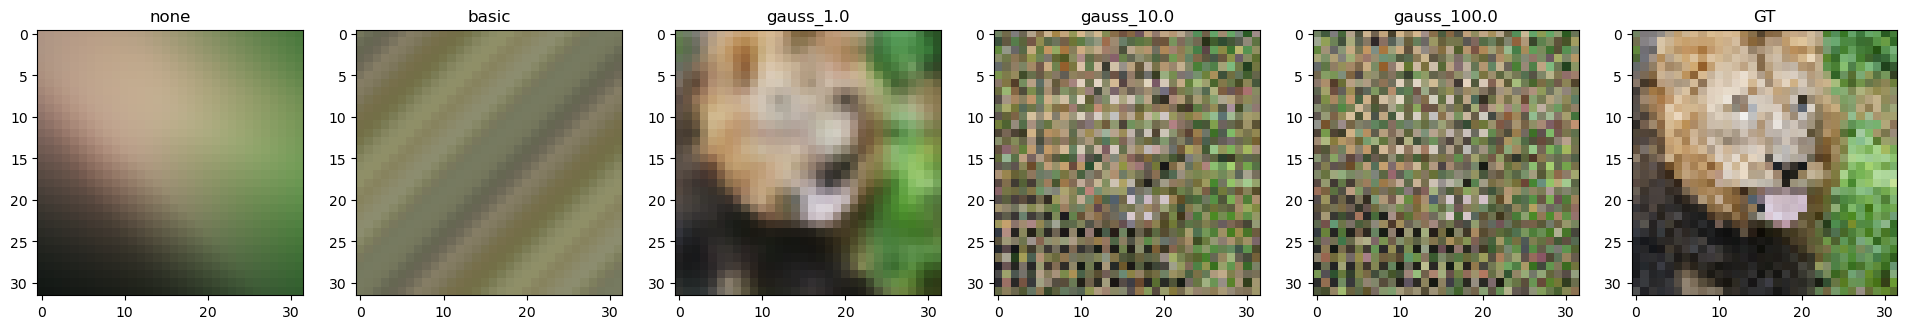

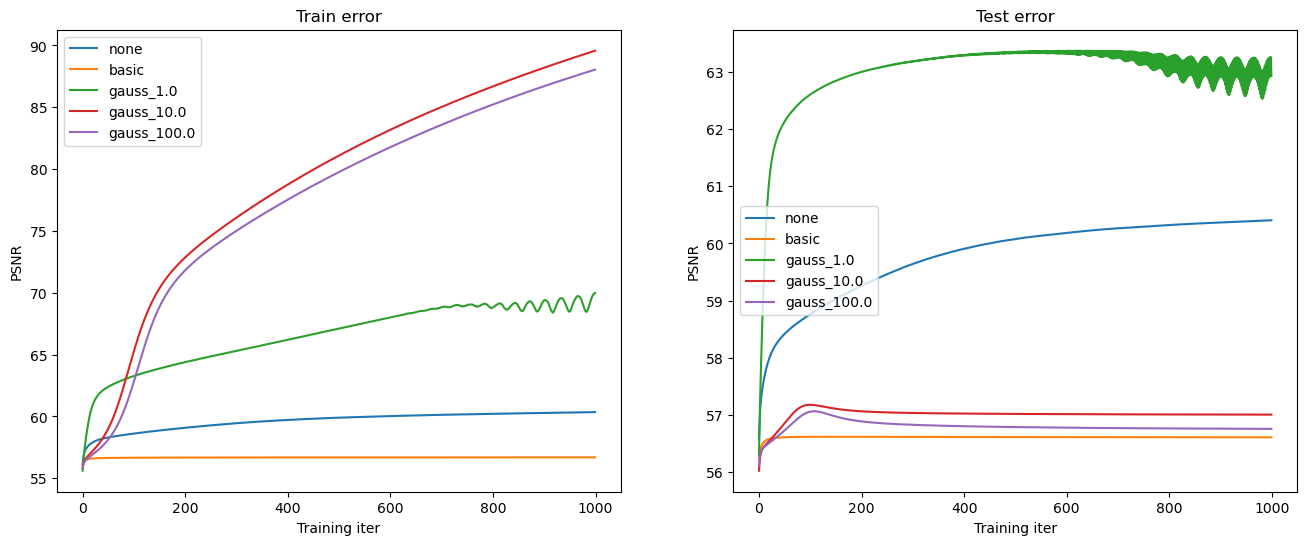

In [84]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# High Resolution Reconstruction

#### High Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

Repeat the previous experiment, but at the higher resolution. The reason why we have you first experiment with the lower resolution since it is faster to train and debug. Additionally, you will see how the mapping strategies perform better or worse at the two different input resolutions. 

In [ ]:
size = 128
train_data, test_data = get_image(size)

In [ ]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size,)

#### High Resolution Reconstruction - Image of your Choice

When choosing an image select one that you think will give you interesting results or a better insight into the performance of different feature mappings and explain why in your report template. 

In [ ]:
size = 128
# TODO pick an image and replace the url string
train_data, test_data = get_image(size, image_url="YOUR URL HERE")

In [ ]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function

plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

# Reconstruction Process Video (Optional)
(For Fun!) Visualize the progress of training in a video 

In [ ]:
# requires installing this additional dependency
!pip install imageio-ffmpeg

In [ ]:
# single video example
create_and_visualize_video({"gauss": {"pred_imgs": predicted_images}}, filename="training_high_res_gauss.mp4")

In [ ]:
# multi video example
create_and_visualize_video(outputs, epochs=1000, size=32)